<a href="https://colab.research.google.com/github/aswinpradeep/indic-supervised-text-classification/blob/main/indic_supervised_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Indic supervised text classification**

Notebook contains several experiments to perform domain classification for text in Indian languages.




## Install necessary libraries

In [ ]:
!pip install indic-nlp-library
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 40 kB 2.4 MB/s 
     |████████████████████████████████| 2.8 MB 8.6 MB/s 
     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 
     |████████████████████████████████| 61 kB 446 kB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.4 MB/s 


##Download & Create dataset

In [ ]:
#Download and extract files

!wget https://anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com/drivespark-en-hi-20210303.zip
!unzip drivespark-en-hi-20210303.zip


!wget https://anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com/mk_20210320_en_hi.zip
!unzip mk_20210320_en_hi.zip

!wget https://anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com/ie_business_20210320_en_hi.zip
!unzip ie_business_20210320_en_hi.zip



--2022-01-10 10:44:53--  https://anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com/drivespark-en-hi-20210303.zip
Resolving anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com (anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com)... 52.218.232.185
Connecting to anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com (anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com)|52.218.232.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3099461 (3.0M) [application/zip]
Saving to: ‘drivespark-en-hi-20210303.zip’

drivespark-en-hi-20 100%[===================>]   2.96M  5.83MB/s    in 0.5s    

2022-01-10 10:44:54 (5.83 MB/s) - ‘drivespark-en-hi-20210303.zip’ saved [3099461/3099461]

Archive:  drivespark-en-hi-20210303.zip
   creating: en-hi/
  inflating: en-hi/ds_train.hi       
  inflating: en-hi/ds_train.en       
  inflating: __MACOSX/en-hi/._ds_train.en  
--2022-01-10 10:44:54--  https://anuvaad-parallel-corpus.s3-us-west-2.amazonaws.com/mk_20210320_en_hi.zip
Resolving an

In [ ]:
#Hardcoded list of and dataset size

DOMAIN0 = "AUTOMOTIVE"
D0_FILE = "/content/en-hi/ds_train.hi"

DOMAIN1 = "SPORTS"
D1_FILE = "/content/en-hi/mk_train.hi"

DOMAIN2 = "FINANCE"
D2_FILE = "/content/en-hi/ie_business_train.hi"

DOMAINS = [DOMAIN0, DOMAIN1, DOMAIN2]
PER_DOMAIN_DATA_LEN = 500
DATASET_LEN = 500

In [ ]:
import pandas as pd 
df0 =  pd.read_csv(D0_FILE, sep="\t", header=None).head(PER_DOMAIN_DATA_LEN)
df0.columns = ["text"]
df0["domain"] = 0

df1 =  pd.read_csv(D1_FILE, sep="\t", header=None).head(PER_DOMAIN_DATA_LEN)
df1.columns = ["text"]
df1["domain"] = 1

df2 =  pd.read_csv(D2_FILE, sep="\t", header=None).head(PER_DOMAIN_DATA_LEN)
df2.columns = ["text"]
df2["domain"] = 2

df = pd.concat([df0, df1, df2], axis=0)
df = df.sample(frac = 1)
df = df.head(DATASET_LEN)
#df['domain'] = df['domain'].map({'financial':0, 'automotive':1 , 'sports':2})
display(df)

,text,domain
384,टीम इंडिया के लिए वर्ष 2015 मिला जुला वर्ष रहा...,1
154,टीम इंडिया इंग्लैंड के खिलाफ वनडे और टी-20 सीर...,1
466,टॉस जीतकर भारत ने शुरु की पारी,1
254,"वर्तमान में मनेसर संयंत्र में कुल 1,100 कर्मचा...",0
244,20 फरवरी को बैंगलुरू में आईपीएल खिलाड़ियों की ...,1
...,...,...
182,"बजाज ऑटो ने दोपहिया बाजार में किया धमाल, बिक्र...",0
467,"सिडनी, 26 नवंबरः एशियाई फुटबाल परिसंघ (एएफसी) ...",1
376,पिछले साल के अगस्त महीने के मुकाबले बिक्री में...,2
481,पूर्व विश्व चैम्पियन बुलगारिया के वेसलिन टोपाल...,1


# Basic data cleanup

In [ ]:
from bs4 import BeautifulSoup
import re


def clean_data(text):
    #fixes html tags displayed in encoded format
    text = BeautifulSoup(text, features = "lxml").string

    #remove html markup
    text = re.sub("(<.*?>)", "", text)

    #remove urls
    text = re.sub(r'http\S+', '', text)

    return text

df['text'] = df['text'].apply(clean_data)
df = df.dropna()
display(df)

,text,domain
384,टीम इंडिया के लिए वर्ष 2015 मिला जुला वर्ष रहा...,1
154,टीम इंडिया इंग्लैंड के खिलाफ वनडे और टी-20 सीर...,1
466,टॉस जीतकर भारत ने शुरु की पारी,1
254,"वर्तमान में मनेसर संयंत्र में कुल 1,100 कर्मचा...",0
244,20 फरवरी को बैंगलुरू में आईपीएल खिलाड़ियों की ...,1
...,...,...
182,"बजाज ऑटो ने दोपहिया बाजार में किया धमाल, बिक्र...",0
467,"सिडनी, 26 नवंबरः एशियाई फुटबाल परिसंघ (एएफसी) ...",1
376,पिछले साल के अगस्त महीने के मुकाबले बिक्री में...,2
481,पूर्व विश्व चैम्पियन बुलगारिया के वेसलिन टोपाल...,1


In [ ]:
#split into train and test dataset
from sklearn.model_selection import train_test_split
df = df.head(DATASET_LEN)
train_df, test_df = train_test_split(df, test_size=0.2)
train_df

train_df.to_csv("train.csv")
test_df.to_csv("test.csv")

In [ ]:
# import pandas as pd
# train_df = pd.read_csv("/content/train.csv")
# test_df = pd.read_csv("/content/test.csv")

In [ ]:
X_train = list(train_df["text"])
X_test = list(test_df["text"])
y_train = list(train_df["domain"])
y_test = list(test_df["domain"])

## Data Statistics

domain
1    143
0    137
2    120
dtype: int64


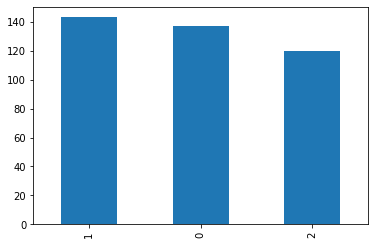

In [ ]:
pd.value_counts(train_df['domain']).plot.bar()
print(train_df.value_counts(train_df['domain']))

domain
1    44
0    29
2    27
dtype: int64


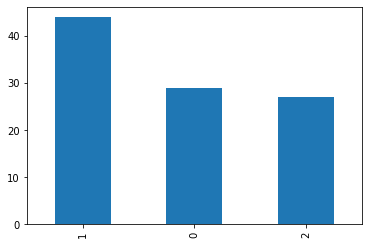

In [ ]:
pd.value_counts(test_df['domain']).plot.bar()
print(test_df.value_counts(test_df['domain']))

## Conventional approaches 

KNN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from indicnlp.tokenize import indic_tokenize  
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import pickle

Results for KNN Classifier with Tfidf vectorizer
0.8


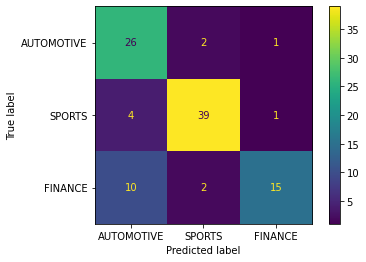

In [31]:

# hindi_stop_words = ["अंदर","अत","अदि","अप","अपना","अपनि","अपनी","अपने","अभि","अभी","आदि","आप","इंहिं","इंहें","इंहों","इतयादि","इत्यादि","इन","इनका","इन्हीं","इन्हें","इन्हों","इस","इसका","इसकि","इसकी","इसके","इसमें","इसि","इसी","इसे","उंहिं","उंहें","उंहों","उन","उनका","उनकि","उनकी","उनके","उनको","उन्हीं","उन्हें","उन्हों","उस","उसके","उसि","उसी","उसे","एक","एवं","एस","एसे","ऐसे","ओर","और","कइ","कई","कर","करता","करते","करना","करने","करें","कहते","कहा","का","काफि","काफ़ी","कि","किंहें","किंहों","कितना","किन्हें","किन्हों","किया","किर","किस","किसि","किसी","किसे","की","कुछ","कुल","के","को","कोइ","कोई","कोन","कोनसा","कौन","कौनसा","गया","घर","जब","जहाँ","जहां","जा","जिंहें","जिंहों","जितना","जिधर","जिन","जिन्हें","जिन्हों","जिस","जिसे","जीधर","जेसा","जेसे","जैसा","जैसे","जो","तक","तब","तरह","तिंहें","तिंहों","तिन","तिन्हें","तिन्हों","तिस","तिसे","तो","था","थि","थी","थे","दबारा","दवारा","दिया","दुसरा","दुसरे","दूसरे","दो","द्वारा","न","नहिं","नहीं","ना","निचे","निहायत","नीचे","ने","पर","पहले","पुरा","पूरा","पे","फिर","बनि","बनी","बहि","बही","बहुत","बाद","बाला","बिलकुल","भि","भितर","भी","भीतर","मगर","मानो","मे","में","यदि","यह","यहाँ","यहां","यहि","यही","या","यिह","ये","रखें","रवासा","रहा","रहे","ऱ्वासा","लिए","लिये","लेकिन","व","वगेरह","वरग","वर्ग","वह","वहाँ","वहां","वहिं","वहीं","वाले","वुह","वे","वग़ैरह","संग","सकता","सकते","सबसे","सभि","सभी","साथ","साबुत","साभ","सारा","से","सो","हि","ही","हुअ","हुआ","हुइ","हुई","हुए","हे","हें","है","हैं","हो","होता","होति","होती","होते","होना","होने"]
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(tokenizer = lambda x: indic_tokenize.trivial_tokenize(x))

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_vec, y_train)

knn_score = knn.score(X_test_vec, y_test)

print("Results for KNN Classifier with Tfidf vectorizer")
print(knn_score)

y_pred_knn = knn.predict(X_test_vec)
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
cmd = ConfusionMatrixDisplay(cm, display_labels=DOMAINS)
cmd.plot()


knnPickle = open('knnpickle_file', 'wb') 

# source, destination 
pickle.dump(knn, knnPickle)   


## Neural Network / BERT approaches


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification,AutoTokenizer,AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback

In [ ]:
  # Create torch dataset
  class Dataset(torch.utils.data.Dataset):
      def __init__(self, encodings, labels=None):
          self.encodings = encodings
          self.labels = labels

      def __getitem__(self, idx):
          item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
          if self.labels:
              item["labels"] = torch.tensor(self.labels[idx])
          return item

      def __len__(self):
          return len(self.encodings["input_ids"])



In [ ]:
 def compute_metrics(p):
      pred, labels = p
      pred = np.argmax(pred, axis=1)

      accuracy = accuracy_score(y_true=labels, y_pred=pred)
      recall = recall_score(y_true=labels, y_pred=pred, average='micro')
      precision = precision_score(y_true=labels, y_pred=pred, average='micro')
      f1 = f1_score(y_true=labels, y_pred=pred, average='micro')
      return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
model_name = "ai4bharat/indic-bert"
indicbert_tokenizer = AutoTokenizer.from_pretrained(model_name, keep_accents=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

X_train_tokenized = indicbert_tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = indicbert_tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)



args = TrainingArguments(
    output_dir="output/indic-bert",
    evaluation_strategy="steps",
    eval_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    logging_dir='logs',           
    logging_steps=50,
    do_train=True,
    do_eval=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    
)

trainer.train()
indicbert_model_path = "output/indic-bert"
model.save_pretrained(indicbert_model_path)


Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.065700,0.921311,0.710000,0.710000,0.710000,0.710000
100,0.637100,0.459224,0.890000,0.890000,0.890000,0.890000
150,0.371900,0.382246,0.910000,0.910000,0.910000,0.910000


***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in output/indic-bert/config.json
Model weights saved in output/indic-bert/pytorch_model.bin


In [ ]:
X_test_tokenized = indicbert_tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model

# model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)
indicbert_out_model = AutoModelForSequenceClassification.from_pretrained(indicbert_model_path, num_labels=3)
indicbert_out_model.to(device)


# Define test trainer
test_trainer = Trainer(indicbert_out_model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)



loading configuration file output/indic-bert/config.json
Model config AlbertConfig {
  "_name_or_path": "output/indic-bert",
  "architectures": [
    "AlbertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_clas

0.91

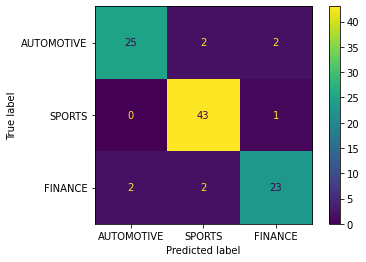

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=DOMAINS)
cmd.plot()
accuracy_score(y_true=y_test, y_pred=y_pred)

In [ ]:
model_name = "google/muril-large-cased"
muril_tokenizer = AutoTokenizer.from_pretrained(model_name, keep_accents=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

X_train_tokenized = muril_tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = muril_tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)



args = TrainingArguments(
    output_dir="output/muril",
    evaluation_strategy="steps",
    eval_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    logging_dir='logs',           
    logging_steps=50,
    do_train=True,
    do_eval=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    
)

trainer.train()
muril_model_path = "output/muril-large-cased"
model.save_pretrained(muril_model_path)


https://huggingface.co/google/muril-large-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp0ev2p_nl


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

storing https://huggingface.co/google/muril-large-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/bf1b2a9bdf1cff111b32340196bd39aecd95702c184ea2489c1268683b4f531e.c685950e8d32cffa796a9b56861350d915f216970457f689f9fe9d9e90f06e24
creating metadata file for /root/.cache/huggingface/transformers/bf1b2a9bdf1cff111b32340196bd39aecd95702c184ea2489c1268683b4f531e.c685950e8d32cffa796a9b56861350d915f216970457f689f9fe9d9e90f06e24
https://huggingface.co/google/muril-large-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjhp8f1_c


Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

storing https://huggingface.co/google/muril-large-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/fbda239b28cad45a6080fac5120af123da0ab1e614b767bc9d46a114ce6153a6.ef3bfb0d9b54a567d874d535fea34f5386e733032065b5d841165d64dcbf0b72
creating metadata file for /root/.cache/huggingface/transformers/fbda239b28cad45a6080fac5120af123da0ab1e614b767bc9d46a114ce6153a6.ef3bfb0d9b54a567d874d535fea34f5386e733032065b5d841165d64dcbf0b72
loading configuration file https://huggingface.co/google/muril-large-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fbda239b28cad45a6080fac5120af123da0ab1e614b767bc9d46a114ce6153a6.ef3bfb0d9b54a567d874d535fea34f5386e733032065b5d841165d64dcbf0b72
Model config BertConfig {
  "_name_or_path": "google/muril-large-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 1024,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

storing https://huggingface.co/google/muril-large-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/eeb6721c92870c84773d423e2e983894008d49ca90d10f7e9fa092451a3d7fbb.6238bf3b1b7ad31c55bb4415faa9477a5f8e50723e8d1d70df19a65433db277f
creating metadata file for /root/.cache/huggingface/transformers/eeb6721c92870c84773d423e2e983894008d49ca90d10f7e9fa092451a3d7fbb.6238bf3b1b7ad31c55bb4415faa9477a5f8e50723e8d1d70df19a65433db277f
https://huggingface.co/google/muril-large-cased/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4z2_9wmm


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/google/muril-large-cased/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/fe115eb36e01f7ae03038ded522b3340928096d8387073f9347ff97b2bd201f2.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/fe115eb36e01f7ae03038ded522b3340928096d8387073f9347ff97b2bd201f2.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/google/muril-large-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/eeb6721c92870c84773d423e2e983894008d49ca90d10f7e9fa092451a3d7fbb.6238bf3b1b7ad31c55bb4415faa9477a5f8e50723e8d1d70df19a65433db277f
loading file https://huggingface.co/google/muril-large-cased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/google/muril-large-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/google/muri

Downloading:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

storing https://huggingface.co/google/muril-large-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/dd0d122a98e678842ba177db8e6af4b241eabb3873d4abb1fb076cb95b844ad4.3c28b8ebf6e4133342d2f89ab4ed734abab1a3d61b1236e3c784682333cb4c7a
creating metadata file for /root/.cache/huggingface/transformers/dd0d122a98e678842ba177db8e6af4b241eabb3873d4abb1fb076cb95b844ad4.3c28b8ebf6e4133342d2f89ab4ed734abab1a3d61b1236e3c784682333cb4c7a
loading weights file https://huggingface.co/google/muril-large-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/dd0d122a98e678842ba177db8e6af4b241eabb3873d4abb1fb076cb95b844ad4.3c28b8ebf6e4133342d2f89ab4ed734abab1a3d61b1236e3c784682333cb4c7a
Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weig

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.329200,0.172426,0.950000,0.950000,0.950000,0.950000
100,0.086300,0.230762,0.950000,0.950000,0.950000,0.950000
150,0.048200,0.130310,0.960000,0.960000,0.960000,0.960000


***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in output/muril-large-cased/config.json
Model weights saved in output/muril-large-cased/pytorch_model.bin


In [ ]:
X_test_tokenized = muril_tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model

# model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)
muril_out_model = AutoModelForSequenceClassification.from_pretrained(muril_model_path, num_labels=3)


# Define test trainer
test_trainer = Trainer(muril_out_model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)



loading configuration file output/muril-large-cased/config.json
Model config BertConfig {
  "_name_or_path": "output/muril-large-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 1024,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 197285
}

loading weights file output/mu

0.96

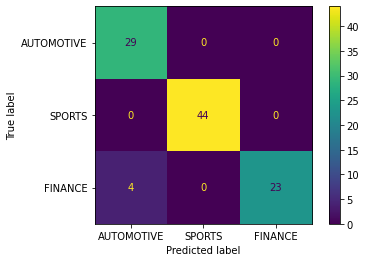

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=DOMAINS)
cmd.plot()
accuracy_score(y_true=y_test, y_pred=y_pred)

# Inference

In [24]:
input_sentence = "सचिन ने पिछले क्रिकेट मैच में कुल 20 रन बनाए और 2 विकेट लिए"

encoding = muril_tokenizer([input_sentence], return_tensors='pt').to(device)
predictions = muril_out_model(**encoding).logits.argmax(-1)

print(" Muril prediction : ", DOMAINS[predictions.item()])

encoding = indicbert_tokenizer([input_sentence], return_tensors='pt').to(device)
predictions = indicbert_out_model(**encoding).logits.argmax(-1)

print(" Indic bert prediction : ", DOMAINS[predictions.item()])


knn_model = pickle.load(open('knnpickle_file', 'rb'))

vct = vectorizer.transform([input_sentence])
predictions = knn_model.predict(vct)

print(" KNN prediction : ", DOMAINS[predictions[0]])


 Muril prediction :  SPORTS
 Indic bert prediction :  SPORTS
 KNN prediction :  SPORTS
